In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
!pip uninstall numpy

^C


In [24]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
# import h5py

import windIO
import wind
import windWT as wt
import windCAD
import windOF as foam
import windCodes

import winsound

from matplotlib.ticker import FuncFormatter

In [5]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [6]:
B = 0.2744
D = 0.183
lScl=1/50.0

Hr = 0.08  # ridge height
roofSlope = np.rad2deg(np.arctan(0.25/12))  # roof slope
He = Hr - D/2.0*np.sin(np.deg2rad(roofSlope))  # eaves height
Havg = np.mean([Hr, He])
H = Havg  # average roof height
print("Hr = {:.5g} m, He = {:.5g} m, Havg = {:.5g} m".format(Hr, He, Havg))

areaFactor_toFSm2 = (1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

fluidDensity = 1.225  # only for wind tunnel
fluidKinematicViscosity = 1.48e-5

badTaps = None
# badTaps = [1316, 1807, 2609,]
badTaps = [1807, 2609,]


Hr = 0.08 m, He = 0.078094 m, Havg = 0.079047 m


In [7]:
tapFile = r"D:/tempData_depot/simData_CandC/tngTapDefinition.csv"
tapInfo = pd.read_csv(tapFile)

faceID = [1,2,3,4,5,6]
name = ['Roof_1','Roof_2','Wall_1','Wall_2','Wall_3','Wall_4']
note = ['','','','','','']
# origin = [[0,0,0.08],
#           [0,-0.0915,0.07809375],
#           [-0.1372,0,0],
#           [0,-0.0915,0],
#           [0.1372,0,0],
#           [0,0.0915,0],]
# basisVectors = [[[1,0,0],[0,0.999783057,0.020828814],[0,-0.020828814,0.999783057]],
#                 [[1,0,0],[0,0.999783057,-0.020828814],[0,0.020828814,0.999783057]],
#                 [[0,0,-1],[-1,0,0],[0,1,0]],
#                 [[1,0,0],[0,0,-1],[0,1,0]],
#                 [[0,0,1],[1,0,0],[0,1,0]],
#                 [[-1,0,0],[0,0,1],[0,1,0]],]

# origin_plt = [[0, 0],
#               [0, 0],
#               [0, 0],
#               [0, 0],
#               [0, 0],
#               [0, 0],
#               ]

# basisVectors_plt = [[[0, 1], [-1, 0]],
#                     [[0, 1], [-1, 0]],
#                     [[0, 1], [-1, 0]],
#                     [[0, 1], [-1, 0]],
#                     [[0, 1], [-1, 0]],
#                     [[0, 1], [-1, 0]],
#                     ]
vertices = [[[-0.091519855,-0.1372],[0,-0.1372],[0,0.1372],[-0.091519855,0.1372],[-0.091519855,-0.1372]],
            [[0,-0.1372],[0.091519855,-0.1372],[0.091519855,0.1372],[0,0.1372],[0,-0.1372]],
            [[-0.0915,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0,-0.1532],[-0.0915,-0.15510625],[-0.0915,-0.2332]],
            [[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,-0.1372]],
            [[-0.0915,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0,0.1532],[-0.0915,0.15510625],[-0.0915,0.2332]],
            [[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,-0.1372]],]

# re-write the 'origin', 'basisVectors', 'origin_plt', 'basisVectors_plt', 'vertices' as a function of B, D, Hr, roofSlope, He, Havg, and H

origin = [[0,0,Hr],
            [0,-D/2,He],
            [-B/2,0,0],
            [0,-D/2,0],
            [B/2,0,0],
            [0,D/2,0],]
basisVectors = [[[1,0,0],[0,np.cos(np.deg2rad(roofSlope)),np.sin(np.deg2rad(roofSlope))],[0,-np.sin(np.deg2rad(roofSlope)),np.cos(np.deg2rad(roofSlope))]],
                [[1,0,0],[0,np.cos(np.deg2rad(roofSlope)),-np.sin(np.deg2rad(roofSlope))],[0,np.sin(np.deg2rad(roofSlope)),np.cos(np.deg2rad(roofSlope))]],
                [[0,0,-1],[-1,0,0],[0,1,0]],
                [[1,0,0],[0,0,-1],[0,1,0]],
                [[0,0,1],[1,0,0],[0,1,0]],
                [[-1,0,0],[0,0,1],[0,1,0]],]

origin_plt = [[0, 0],
                [0, 0],
                [0, 0],
                [0, 0],
                [0, 0],
                [0, 0],
                ]

basisVectors_plt = [[[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    ]
offset = 0.01790584
print(vertices[3][0])
vertices = [[[-D/2,-B/2],[0,-B/2],[0,B/2],[-D/2,B/2],[-D/2,-B/2]],
            [[0,-B/2],[D/2,-B/2],[D/2,B/2],[0,B/2],[0,-B/2]],
            [[-D/2,-B/2-He-offset],[D/2,-B/2-He-offset],[D/2,-B/2-offset],[0,-B/2-offset],[-D/2,-B/2-offset],[-D/2,-B/2-He-offset]],
            [[Hr+offset,-B/2],[Hr+offset,B/2],[D/2,B/2],[D/2,-B/2],[Hr+offset,-B/2]],
            [[-D/2,B/2+offset],[D/2,B/2+offset],[D/2,B/2+He+offset],[0,B/2+He+offset],[-D/2,B/2+He+offset],[-D/2,B/2+offset]],
            [[-Hr-offset,-B/2],[-Hr-offset,B/2],[-D/2,B/2],[-D/2,-B/2],[-Hr-offset,-B/2]],
]
print(vertices[3][0])

[0.107519855, -0.1372]
[0.09790584, -0.1372]


In [8]:
faces_ASCE = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                )
    faces_ASCE.append(fc)

Generating panels ...
Generating panels ...
Generating panels ...
Generating panels ...
Generating panels ...
Generating panels ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:178: UserWarning: The sum of tributary areas 0.0 is not equal to the area of the bound 0.0017577624959999988.
  warnings.warn(f"The sum of tributary areas {totalArea} is not equal to the area of the bound {boundArea}.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:178: UserWarning: The sum of tributary areas 0.0 is not equal to the area of the bound 0.0017577624959999988.
  warnings.warn(f"The sum of tributary areas {totalArea} is not equal to the area of the bound {boundArea}.")


In [9]:
bldg = wind.bldgCp(bldgName='TTU_1to50_TNG',
                faces=faces_ASCE,
                H=H, He=He, Hr=Hr,
                D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='GeomDefinition',
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='CCW',
                )
print(json.dumps(bldg.panelingErrors, indent=4, separators=(',', ':')))

Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.

{
    "Face 1":null,
    "Face 2":null,
    "Face 3":null,
    "Face 4":null,
    "Face 5":null,
    "Face 6":null
}


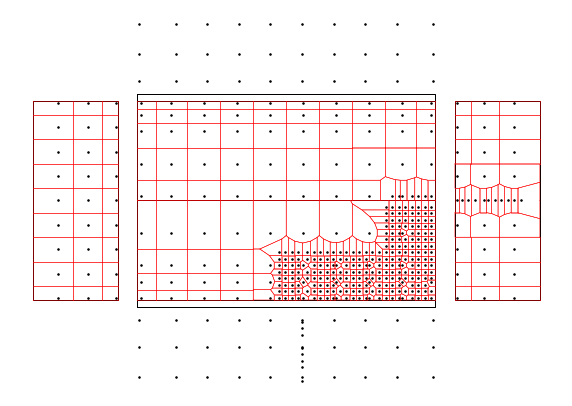

In [10]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)

bldg.plotEdges(ax=ax,showName=False)
bldg.plotTaps(ax=ax)
bldg.plotTribs(ax=ax)
# bldg.plotZones(ax=ax,showLegend=False)
# bldg.plotPanels(ax=ax,)

ax.set_aspect('equal')
_ = ax.axis('off')


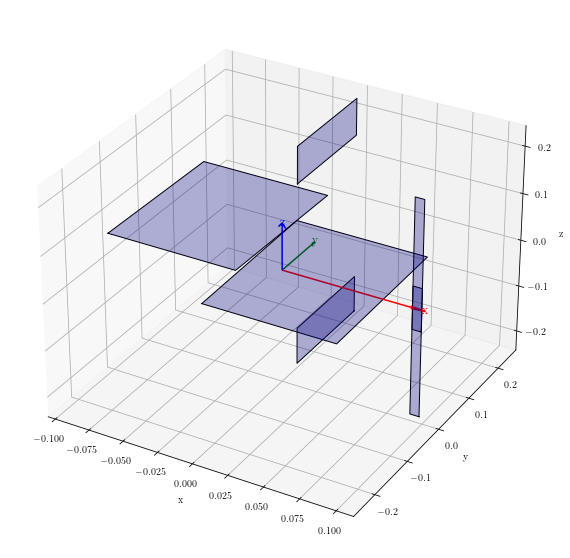

In [11]:
# fig = plt.figure(figsize=[15,15])
# ax = fig.add_subplot(111)

bldg.plotBldg_3D()

# ax.set_aspect('equal')
# _ = ax.axis('off')

In [12]:
rawHFPIdir = r"F:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/gable27deg/"
figDir = outputDir + r"__plots/"
exportDir = outputDir + r"__export/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"

H = 80*wind.UNIT_CONV['mm2m']  # average roof height
Hr = 97.5*wind.UNIT_CONV['mm2m']  # ridge height
He = 62.5*wind.UNIT_CONV['mm2m']  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.UNIT_CONV['mm2m']
D = 138.7*wind.UNIT_CONV['mm2m']
roofSlope = 26.1  # roof slope
site_latitude = 46.1

lScl=1/100.0
vScl=1/2.78
tScl=lScl/vScl

areaFactor_toFSm2 = 1/(1000**2)*(1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale
dur_MS_1hr = 3600*tScl
badTaps = []

print("lScl = {:.5f}".format(lScl))
print("tScl = {:.5f}".format(tScl))
print("vScl = {:.5f}".format(vScl))
print(f"Model-scale duration = {dur_MS_1hr:.2f} seconds")

lScl = 0.01000
tScl = 0.02780
vScl = 0.35971
Model-scale duration = 100.08 seconds


In [13]:

tapData = pd.read_csv(tapFile, na_filter=False)
all_fullScaleTaps=  [101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
all_fullScaleTaps=  [101, 111, 102, 112, 109, 110, 2004, 104, 106, 405, 314, 212, 316, 402, 301]
fullScaleTaps=      [101, 111, 102, 112, 109, 110, 104, 106, 405, 314, 212, 316, 402, 301]  # remove 1911 (PT7)

faceID = [1,2,3,4,5,6]
name = [r'West roof',r'East roof',r'East wall',r'North wall',r'West wall',r'South wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]


In [14]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 180.0, 470.0, 785.0, 3200, 10000]

faces = []
for i,z in enumerate(faceID):
    print(f"Processing face {z}...")
    idx = tapData.index[tapData.faceID == z]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    if z == 2:  # flip the y-coordinates about the centreline defined by average of the edge vertices. 
                # The aerodynamics strongly suggests that Face 2 must have been flipped in the tubing process.
        x = np.array(vertices_basic[i])
        yAvg = np.mean([min(x[:,1]), max(x[:,1])])
        tapCoords[:,1] = yAvg - (tapCoords[:,1] - yAvg)

    fc = windCAD.face(
                name=f'Face {z} ('+name[i]+')',
                ID=z,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                # zoneDict=zoneDict_basic[i],
                # nominalPanelAreas=nominalPanelAreas, 
                showDetailedLog=False,
                )
    faces.append(fc)
    fc.error_in_panels
    print(f"Face {z} done.\n\n\n")


Processing face 1...
Generating panels ...
Face 1 done.



Processing face 2...
Generating panels ...
Face 2 done.



Processing face 3...
Generating panels ...
Face 3 done.



Processing face 4...
Generating panels ...
Face 4 done.



Processing face 5...
Generating panels ...
Face 5 done.



Processing face 6...
Generating panels ...
Face 6 done.





In [15]:
bldg_iso = wind.bldgCp(bldgName=r'NRC-NB 1:100 UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName=r'Case 2 [x]',
                notes_Cp=r'Generic isolated case.',
                )

Refreshing Case 2 [x]...
Verifying data ...
Done refreshing Case 2 [x].



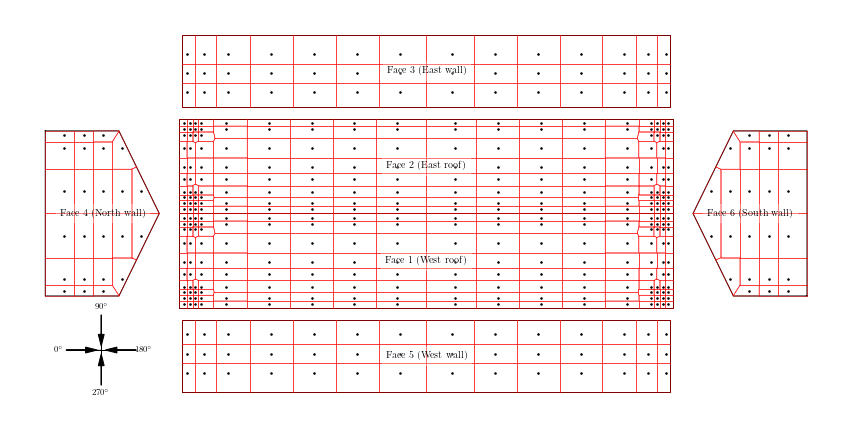

In [16]:
fig = plt.figure(figsize=[12,6])
axs = fig.subplots(1,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

ax = axs
# ax.text(0.5, 0.95, r'(a) Isolated', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_iso.plotEdges(ax=ax,showName=True)
bldg_iso.plotTaps(ax=ax,showTapNo=False)
bldg_iso.plotTribs(ax=ax,)
bldg_iso.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')


plt.show()

# # if saveFigs:
# fig.savefig(figDir+"tapLayout_tex.svg",format='svg',dpi=1200, bbox_inches='tight')


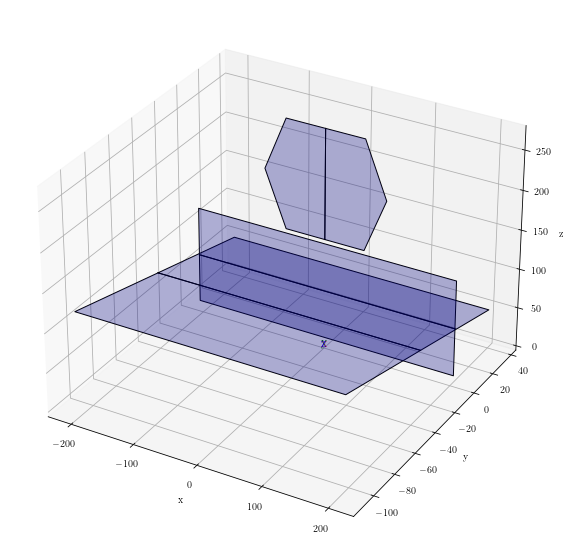

In [17]:
bldg_iso.plotBldg_3D()